## CV classification task on CIFAR dataset

### Importing modules

In [ ]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchsummary
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Loading and preparing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/models/resnet50.py' .

In [ ]:
import utils
import imp
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
from utils import train_model

In [ ]:
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

In [ ]:
root_path = '/content/cifar10'
mkdir(root_path)

Directory /content/cifar10 is created!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
NUM_WORKERS = 4
BATCH_SIZE = 128
VAL_RATIO = 0.2

In [ ]:
train_loader, val_loader = utils.get_train_valid_loader(root_path, 
                                                        BATCH_SIZE, 
                                                        VAL_RATIO, 
                                                        NUM_WORKERS)

test_loader = utils.get_test_loader(root_path,
                                    BATCH_SIZE,
                                    NUM_WORKERS)

Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10
Files already downloaded and verified
Files already downloaded and verified


### Testing `ResNet50` implemented from scratch

In [ ]:
import resnet50
imp.reload(resnet50)

<module 'resnet50' from '/content/resnet50.py'>

In [ ]:
model = resnet50.ResNet50(resnet50.ConvBlock, num_classes=10)

In [ ]:
model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res_connection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(in

In [ ]:
N_EPOCHS = 10
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=100)

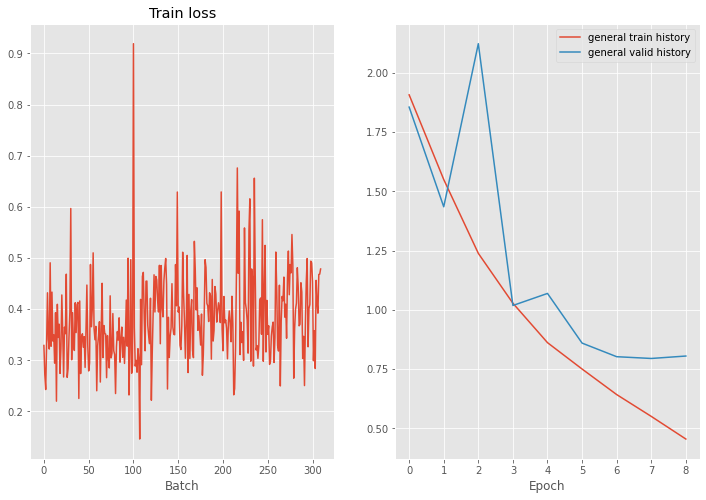

Epoch: 10 | Time: 0m 53s
	Train Loss: 0.382
	 Val. Loss: 0.846


In [ ]:
train_model(model, device, train_loader, val_loader, opt, criterion, lr_scheduler, N_EPOCHS, clip=1)

### Testing pretrained models

Let's use some prepared [models for classification](https://pytorch.org/docs/stable/torchvision/models.html#classification) from torchvision. We will apply pretrained versions of models to use them as feature extractors and also train these models from scratch to compare their perfomances.

#### Densenet-201

##### Pretrained

In [ ]:
densenet201 = models.densenet201(pretrained=True)

In [ ]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in densenet201.parameters():
    param.requires_grad = False

fc_in = densenet201.classifier.in_features
densenet201.classifier = nn.Linear(fc_in, 10)

densenet201.to(device)

In [ ]:
N_EPOCHS = 10
opt = torch.optim.Adam(densenet201.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

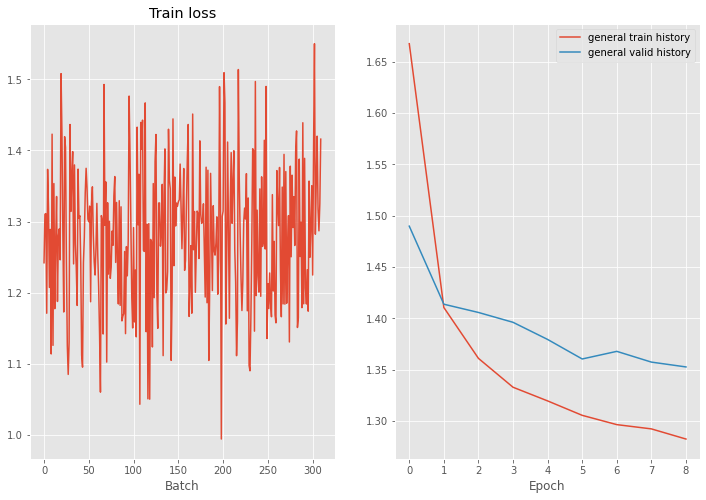

Epoch: 10 | Time: 0m 38s
	Train Loss: 1.279
	 Val. Loss: 1.351


In [ ]:
train_model(densenet201, device, train_loader, val_loader, opt, criterion, lr_scheduler, N_EPOCHS, clip=1)

#### MobileNet V2

##### Pretrained

In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True)

In [ ]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in mobilenet.parameters():
    param.requires_grad = False

fc_in = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Linear(fc_in, 10)

mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

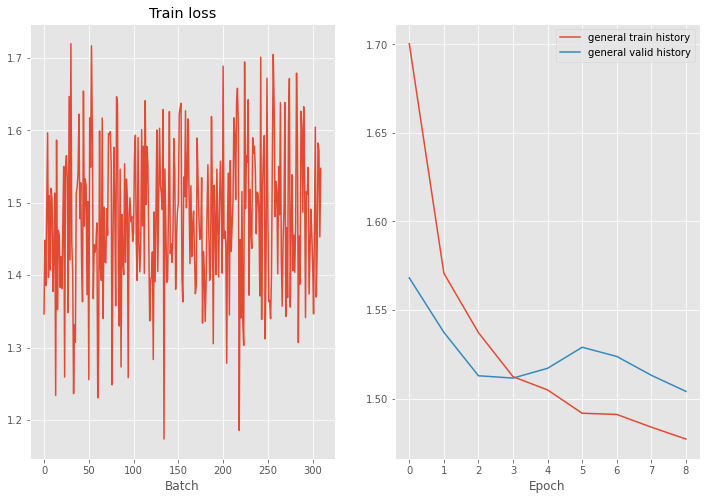

Epoch: 10 | Time: 0m 24s
	Train Loss: 1.479
	 Val. Loss: 1.521


In [ ]:
train_model(mobilenet, device, train_loader, val_loader, opt, criterion, lr_scheduler, N_EPOCHS, clip=1)

In [ ]:
# writer = SummaryWriter() 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs